# Second model presupposition - Polish Dataset

In [22]:
!pip install transformers
!pip install -q pyyaml h5py
import pandas as pd
from transformers import *
import numpy as np
from sklearn.model_selection import train_test_split


## Data Preprocessing

*   Reading data
*   Change columns names
*   Drop NaN rows
*   Fill others NaN values by special sign

In [23]:
df = pd.read_excel('polishOriginalDataset.xlsx')
df.reset_index()
df = df.iloc[:,[6,8,9,10,15,16,19,21,23]]
df.columns = [
              "type_of_sentence",
              "verb_main_semantic_class",
              "verb_second_semantic_class",
              "verb_third_semantic_class",
              "verb_veridical_positive",
              "verb_veridical_negative",
              "verb_tense",
              "t_negation",
              "presupposition"
              ]
df.dropna(inplace=True, axis = 0, how = 'all')
df.fillna(axis = 0, inplace =True, value="none")
df.head()

,type_of_sentence,verb_main_semantic_class,verb_second_semantic_class,verb_third_semantic_class,verb_veridical_positive,verb_veridical_negative,verb_tense,t_negation,presupposition
0,eliptyczne,mówienia,none,none,o?,?,brak,0,nie dotyczy
1,eliptyczne,epistemiczny,none,none,?,?,past,0,no
2,eliptyczne,mówienia,none,none,?,?,past,0,nie dotyczy
3,1,epistemiczny,percepcyjny,none,"""+""","""+""",past,0,nie dotyczy
4,1,epistemiczny,percepcyjny,none,o,o,present,0,nie dotyczy


### Cleaning data by deleting uncertainty - simplification 

In [0]:
# df.type_of_sentence.unique() cleaning not needed 

# df.verb_main_semantic_class - only (epistemiczny, mówienia, ?)
main_semantic_class_unique = df.verb_main_semantic_class.unique()
main_semantic_class_unique = main_semantic_class_unique[main_semantic_class_unique != "epistemiczny"]
main_semantic_class_unique = main_semantic_class_unique[main_semantic_class_unique != "mówienia"]
df.verb_main_semantic_class = df.verb_main_semantic_class.apply(lambda x: '?' if x in main_semantic_class_unique else x )

# df.verb_second_semantic_class.unique() cleaning not needed 
# df.verb_third_semantic_class.unique() cleaning not needed

# verb veridical positive cleaning
df.verb_veridical_positive = df.verb_veridical_positive.apply(lambda x: '+' if '+' in x else x)
df.verb_veridical_positive = df.verb_veridical_positive.apply(lambda x: '-' if '-' in x else x)
df.verb_veridical_positive = df.verb_veridical_positive.apply(lambda x: 'o' if 'o' in x else x)
df.verb_veridical_positive = df.verb_veridical_positive.apply(lambda x: '?' if '?' in x else x)

# verb veridical negative cleaning
df.verb_veridical_negative = df.verb_veridical_negative.apply(lambda x: '+' if '+' in x else x)
df.verb_veridical_negative = df.verb_veridical_negative.apply(lambda x: 'o' if 'o' in x else x)
df.verb_veridical_negative = df.verb_veridical_negative.apply(lambda x: '-' if '-' in x else x)
df.verb_veridical_negative = df.verb_veridical_negative.apply(lambda x: '?' if '?' in x else x)

# df.verb_tense.unique() cleaning not needed
# df.t_negation.unique() cleaning not needed
# df.semantic_relation.unique() cleaning not needed 

df = df[df["presupposition"] != "nie dotyczy"]

#### Possible feature values

In [25]:
print(df.type_of_sentence.unique())
print(df.verb_main_semantic_class.unique())
print(df.verb_second_semantic_class.unique())
print(df.verb_third_semantic_class.unique())
print(df.verb_veridical_positive.unique())
print(df.verb_veridical_negative.unique())
print(df.verb_tense.unique())
print(df.t_negation.unique())


['eliptyczne' 1 'modalne' 'powinnościowe' 'none' '?' 'warunkowe; pytajne'
 'performatyw' 'imperatyw' 'pytajne' 'wolitywne' 'warunkowe; modalne'
 'generalne' 'modalne; pytajne' 'imperatyw ' 'warunkowe']
['epistemiczny' '?' 'mówienia']
['none' 'percepcyjny' 'epistemiczny' 'emotywny' 'wolicjonalny'
 'wnioskowania' 'pamięciowy' 'zdarzeniowy' 'mówienia']
['none' 'mówienia' 'epistemiczny' 'percepcyjny']
['?' 'o' '+' '-']
['?' 'o' '+' '-']
['past' 'brak' 'present' 'future']
[0 1]


In [0]:
df = df[[
         "verb_main_semantic_class",
         "verb_veridical_positive",
         "verb_veridical_negative",
         "verb_tense",
         "presupposition"
         ]]
df.to_csv("plDataPresup.csv", index=False)

In [27]:
df.columns

Index(['verb_main_semantic_class', 'verb_veridical_positive',
       'verb_veridical_negative', 'verb_tense', 'presupposition'],
      dtype='object')

### Vactorize data and split to features and target

Ml classifier labels - target for RandomForest

In [0]:
ml_classifier_labels = df["presupposition"]

#### Vectorize (one =hot encoding)

In [0]:
df = pd.get_dummies(df)

#### Split to features and target

In [0]:
X = df.iloc[:,0:-2]
y = df.iloc[:,-2:]

#### Features columns

In [31]:
X.columns

Index(['verb_main_semantic_class_?', 'verb_main_semantic_class_epistemiczny',
       'verb_main_semantic_class_mówienia', 'verb_veridical_positive_+',
       'verb_veridical_positive_-', 'verb_veridical_positive_?',
       'verb_veridical_positive_o', 'verb_veridical_negative_+',
       'verb_veridical_negative_-', 'verb_veridical_negative_?',
       'verb_veridical_negative_o', 'verb_tense_brak', 'verb_tense_future',
       'verb_tense_past', 'verb_tense_present'],
      dtype='object')

#### Target columns

In [32]:
y.columns

Index(['presupposition_no', 'presupposition_yes'], dtype='object')

## k-fold crossvalidation preparing

You can change number of validations here

In [0]:
k=7
from sklearn.model_selection import KFold
kfold = KFold(n_splits = k, shuffle=True)

acc_per_fold = []
loss_per_fold = [] 

***
# Keras model building

### Train model

In [0]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from sklearn.metrics import confusion_matrix 
import seaborn as sns

It takes only 1-2 minutes to train this model with 7-crossvalidation.

In [35]:
fold_no = 1 

#get number of columns in training data
n_cols = X.shape[1]
print(n_cols)

for train, test in kfold.split(X,y):
  # FOLD PRINTOUT
  print(100*'_')
  print (f"FOLD NO {fold_no} START")  

  # model architecture  
  model = tf.keras.Sequential()
  #add model layers
  model.add(Dense(8, activation='relu', input_shape=(n_cols,)))
  model.add(Dense(16, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(2, activation='softmax'))

  # model compile 
  model.compile(optimizer = 'adam', loss="categorical_crossentropy", metrics = ['accuracy'])
  
  # training
  history = model.fit(X.iloc[train], y.iloc[train], validation_split=0.2, epochs=70)

  # scores 
  scores = model.evaluate(X.iloc[test], y.iloc[test], verbose=0)
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # iterator up
  fold_no = fold_no + 1

15
____________________________________________________________________________________________________
FOLD NO 1 START
Epoch 1/70
17/17 [==============================] - 0s 8ms/step - loss: 0.7217 - accuracy: 0.4198 - val_loss: 0.6728 - val_accuracy: 0.6183
Epoch 2/70
17/17 [==============================] - 0s 3ms/step - loss: 0.6781 - accuracy: 0.5649 - val_loss: 0.5689 - val_accuracy: 0.9008
Epoch 3/70
17/17 [==============================] - 0s 3ms/step - loss: 0.6434 - accuracy: 0.6240 - val_loss: 0.5027 - val_accuracy: 0.9008
Epoch 4/70
17/17 [==============================] - 0s 3ms/step - loss: 0.6177 - accuracy: 0.6756 - val_loss: 0.4583 - val_accuracy: 0.9160
Epoch 5/70
17/17 [==============================] - 0s 3ms/step - loss: 0.5870 - accuracy: 0.6966 - val_loss: 0.4211 - val_accuracy: 0.9160
Epoch 6/70
17/17 [==============================] - 0s 3ms/step - loss: 0.5505 - accuracy: 0.6947 - val_loss: 0.3761 - val_accuracy: 0.9160
Epoch 7/70
17/17 [======================

### Scores

In [36]:
# == Provide average scores ==
print('Score per fold:')
for i in range(0, len(acc_per_fold)):
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Score per fold:
> Fold 1 - Loss: 0.3937595784664154 - Accuracy: 86.36363744735718%
> Fold 2 - Loss: 0.2673208713531494 - Accuracy: 86.36363744735718%
> Fold 3 - Loss: 0.22840748727321625 - Accuracy: 89.90825414657593%
> Fold 4 - Loss: 0.41978636384010315 - Accuracy: 82.56880640983582%
> Fold 5 - Loss: 0.35698917508125305 - Accuracy: 84.40366983413696%
> Fold 6 - Loss: 0.47559353709220886 - Accuracy: 78.899085521698%
> Fold 7 - Loss: 0.3228831887245178 - Accuracy: 82.56880640983582%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 84.43941388811383 (+- 3.273450497239789)
> Loss: 0.35210574311869486
------------------------------------------------------------------------


## plot with train and test accuracy

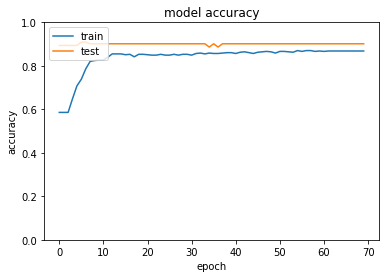

In [37]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

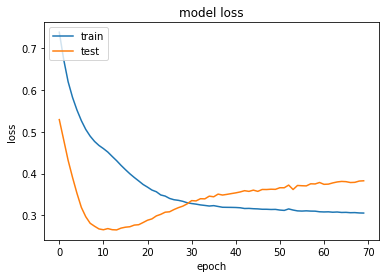

In [38]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')
plt.show()

Confusion matrix 

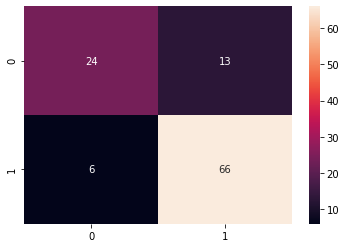

In [39]:
X_conf_matrix = X.iloc[test]
y_conf_matrix = y.iloc[test]
predicted_conf_matrix = model.predict_classes(X_conf_matrix)

conf_matrix = confusion_matrix(y_conf_matrix.values.argmax(axis=1), predicted_conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt="d")

### Save model 


In [0]:
model.save('featureModelPlPresup.h5')

## Check RANDOM FOREST Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
random_forest = RandomForestClassifier(
    n_estimators = 2000, 
)

In [43]:
 X_train, X_test, y_train, y_test = train_test_split(X, ml_classifier_labels, test_size=0.33, random_state=42)
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

(253,)
['no' 'yes']
(253,)
(array(['no', 'yes'], dtype=object), array([ 97, 156]))


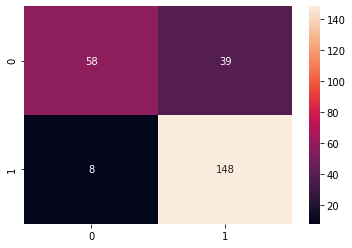

In [44]:
predict = random_forest.predict(X_test)
print(predict.shape)
print(np.unique(predict))
print(y_test.shape)
print(np.unique(y_test, return_counts = True))
conf_matrix = confusion_matrix(y_test, predict)
sns.heatmap(conf_matrix, annot=True, fmt="d")

In [45]:
random_forest.score(X_test, y_test)

0.8142292490118577